In [1]:
#allows imports from other folders in project
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# ARDL model

### Load Data

In [2]:
import pandas as pd
import numpy as np
from Helper.dataPreprocessing import TRAIN_DATA_PATH_1990S

# Loading the data
df = pd.read_csv(TRAIN_DATA_PATH_1990S)

# Convert to datetime and set as index
df["observation_date"] = pd.to_datetime(df["observation_date"])
df.set_index("observation_date", inplace=True)

C:\Users\George\AppData\Local\Temp\ipykernel_8256\3149671297.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["observation_date"] = pd.to_datetime(df["observation_date"])


### Data Preprocessing

In [3]:
from Helper.dataPreprocessing import add_modified_feature

# Identify target column and add new column
target_col = 'fred_PCEPI'
df = add_modified_feature(df, target_col, np.log)
log_col = df.columns[-1]

In [4]:
from Helper.dataPreprocessing import best_lag_selection, train_val_test_split

# Train/Test split and best lag selection
train_X, train_y, _, _, test_X, test_y = train_val_test_split(df[log_col], df[target_col], train_size=0.9, val_size=0)

print(f"Train set size: {len(train_X)}")
print(f"Test  set size: {len(test_X)}")

best_lag = best_lag_selection(train_X, max_lags=12)
print(f"Selected best lag (TRAIN only) for ARDL in levels: {best_lag}")

Train set size: 334
Test  set size: 38
Selected best lag (TRAIN only) for ARDL in levels: 1


### Define and Fit ARDL Model

In [5]:
from statsmodels.tsa.ardl import ARDL

# ARDL model with a linear trend since no exogenous variables
final_model = ARDL(endog=train_X, lags=best_lag, trend='ct').fit()
print(final_model.summary())

                              ARDL Model Results                              
Dep. Variable:         log_fred_PCEPI   No. Observations:                  334
Model:                       ARDL(1,)   Log Likelihood                1621.199
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Tue, 25 Mar 2025   AIC                          -3234.398
Time:                        10:33:20   BIC                          -3219.165
Sample:                    02-01-1990   HQIC                         -3228.324
                         - 10-01-2017                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0515      0.031      1.653      0.099      -0.010       0.113
trend              1.593e-05   1.23e-05      1.298      0.195   -8.22e-06    4.01e-05
log_fred_PCEPI.L1     0.

c:\Users\George\source\repos\COMP5530M-Group-Project-Inflation-Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Make Predictions

In [6]:
from pykalman import KalmanFilter

# Forecast in log-levels
start_idx = test_X.index[0]
end_idx   = test_X.index[-1]

pred_log_test = final_model.predict(start=start_idx, end=end_idx)
pred_log_test = pd.Series(pred_log_test, index=test_X.index)

# Exponentiate to get back to original scale (raw predictions)
predictions_raw = np.exp(pred_log_test)  # "raw" ARDL forecast in original PCEPI scale

# Kalman Filter on the test forecast 
kf = KalmanFilter(initial_state_mean=predictions_raw.iloc[0], n_dim_obs=1)
kf = kf.em(predictions_raw, n_iter=5)

predictions_smoothed_arr, _ = kf.filter(predictions_raw)
predictions_smoothed = pd.Series(predictions_smoothed_arr.flatten(), 
                                 index=predictions_raw.index)

c:\Users\George\source\repos\COMP5530M-Group-Project-Inflation-Forecasting\.venv\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


### Evaluate


=== Evaluation on Test Set ===
RAW Forecast  =>  MAE = 0.3010,  RMSE = 0.4066
Smoothed      =>  MAE = 0.3156,  RMSE = 0.4019


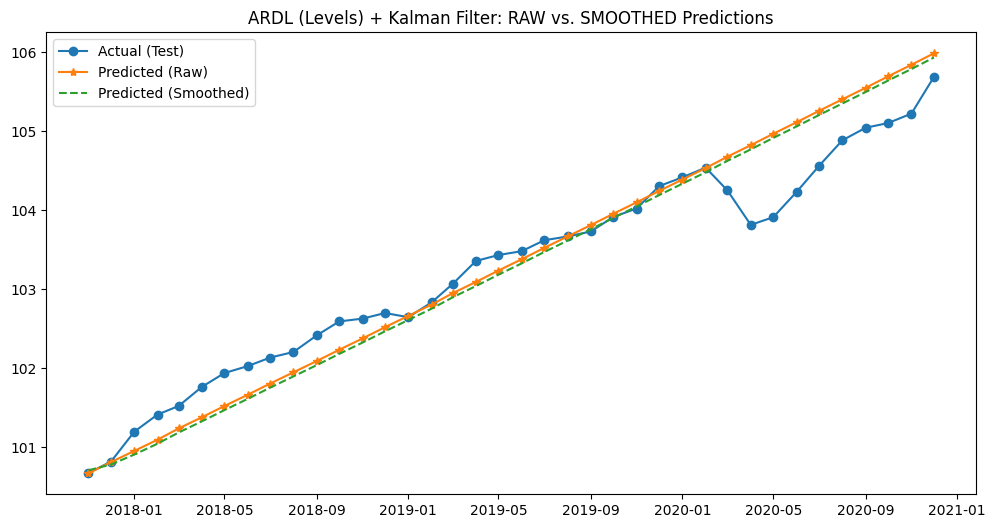

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
# Evaluation
y_true = test_y

# Align both raw and smoothed with the test index
y_pred_raw     = predictions_raw.reindex(y_true.index)
y_pred_smoothed = predictions_smoothed.reindex(y_true.index)

# Evaluate RAW
mae_raw = mean_absolute_error(y_true, y_pred_raw)
rmse_raw = np.sqrt(mean_squared_error(y_true, y_pred_raw))

# Evaluate SMOOTHED
mae_smooth = mean_absolute_error(y_true, y_pred_smoothed)
rmse_smooth = np.sqrt(mean_squared_error(y_true, y_pred_smoothed))

print(f"\n=== Evaluation on Test Set ===")
print(f"RAW Forecast  =>  MAE = {mae_raw:.4f},  RMSE = {rmse_raw:.4f}")
print(f"Smoothed      =>  MAE = {mae_smooth:.4f},  RMSE = {rmse_smooth:.4f}")

# Plotting
plt.figure(figsize=(12,6))
plt.plot(y_true.index, y_true, label="Actual (Test)", marker="o")
plt.plot(y_pred_raw.index, y_pred_raw, label="Predicted (Raw)", marker="*")
plt.plot(y_pred_smoothed.index, y_pred_smoothed, 
         label="Predicted (Smoothed)", linestyle="--")
plt.legend()
plt.title("ARDL (Levels) + Kalman Filter: RAW vs. SMOOTHED Predictions")
plt.show()

# With Exogenous Variables to catch trends

### Data Preprocessing

In [ ]:
#TODO: Have this match with version on /evaluation
# Split into train and test sets
exogenous_columns = [col for col in df.columns if col not in [log_col, target_col]]
train_X, train_y, _, _, test_X, test_y = train_val_test_split(df[exogenous_columns], df[target_col], train_size=0.8, val_size=0)

print(f"Train set size: {len(train_X)}")
print(f"Test  set size: {len(test_X)}")

Train set size: 296
Test  set size: 74


In [38]:
display(df)

,fred_PCEPI,fred_AAAFFM,fred_AAAFFM_PC1,fred_AHETPI,fred_AHETPI_LOG,fred_APU000072610_PCA,fred_APU000074714,fred_APU000074714_CCA,fred_APU000074714_CCH,fred_APU000074714_CH1,...,CMO-Historical-Data-Monthly_Other_raw_materials_diff,CMO-Historical-Data-Monthly_Other_raw_materials_rolling,CMO-Historical-Data-Monthly_Fertilizers_diff,CMO-Historical-Data-Monthly_Fertilizers_rolling,CMO-Historical-Data-Monthly_Metals_minerals_diff,CMO-Historical-Data-Monthly_Metals_minerals_rolling,CMO-Historical-Data-Monthly_Base metals_diff,CMO-Historical-Data-Monthly_Base metals_rolling,CMO-Historical-Data-Monthly_Precious_metals_diff,CMO-Historical-Data-Monthly_Precious_metals_rolling
observation_date,,,,,,,,,,,,,,,,,,,,,
1990-03-01,59.033,1.09,-2280.00000,10.11,2.31353,0.00000,1.023,-16.31093,-1.35924,0.083,...,0.170969,51.221004,0.611609,32.565042,4.233978,42.258476,5.218206,46.902393,-1.747166,31.745087
1990-04-01,59.157,1.20,-2500.00000,10.12,2.31451,15.86333,1.044,24.38400,2.03200,-0.021,...,1.019316,51.890354,0.626561,33.108534,-0.355159,43.295781,-0.437718,48.180829,-1.244372,30.915784
1990-05-01,59.290,1.29,-637.50000,10.16,2.31846,0.00000,1.061,19.38284,1.61524,-0.058,...,1.205232,52.688859,-0.554268,33.336502,0.364438,44.710201,0.449155,49.924044,-0.295699,29.820039
1990-06-01,59.552,0.97,-325.58140,10.20,2.32239,133.35969,1.088,30.15515,2.51293,-0.026,...,1.142441,53.811188,0.221897,33.434565,-0.553513,44.528790,-0.682182,49.700462,-1.228337,28.897236
1990-07-01,59.699,1.09,-451.61290,10.22,2.32435,-12.81556,1.084,-4.41989,-0.36832,-0.008,...,0.554303,54.778514,0.056745,33.342690,1.204920,44.867405,1.485016,50.117791,0.602488,28.590053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,104.887,2.16,151.16279,24.80,3.21084,0.00000,2.177,0.55134,0.04595,-0.478,...,1.809496,62.345281,6.295935,72.818469,4.390898,78.749590,3.411534,79.371655,13.881877,139.703859
2020-09-01,105.046,2.22,126.53061,24.82,3.21165,0.00000,2.193,8.78722,0.73227,-0.437,...,0.005572,63.092638,1.344535,76.603973,1.634702,82.561870,1.587598,82.983777,-4.218168,146.293461
2020-10-01,105.106,2.26,91.52542,24.84,3.21246,-16.17792,2.159,-18.75038,-1.56253,-0.514,...,3.301981,64.798321,0.177043,79.209811,0.377487,84.696233,1.097929,85.016131,-2.859408,148.561562


In [32]:
from Helper.dataPreprocessing import drop_near_constant_cols

# Remove near-constant columns according to standard deviation (there are none in the current dataset)
train_X_clean, dropped_cols = drop_near_constant_cols(train_X, threshold=1e-6)
test_X_clean = test_X.drop(columns=dropped_cols)
print(f"\nDropped near-constant exogenous columns: {dropped_cols}")
print(f"Number of remaining exogenous columns after drop: {len(train_X_clean.columns)}")


Dropped near-constant exogenous columns: []
Number of remaining exogenous columns after drop: 1035


Feature Standardization with PCA To enhance the predictive performance of the ARDL model, I standardized the features using sklearn_fit_transform. This step ensures that the exogenous variables are on the same scale, preventing certain features from dominating the model due to larger magnitude differences. Additionally, I used Principal Component Analysis (PCA) to reduce dimensionality and capture the most relevant information.

In [33]:
from Helper.dataPreprocessing import sklearn_fit_transform
from sklearn.decomposition import PCA

NUM_COMPONENTS = 10

train_exog, test_exog = sklearn_fit_transform(train_X_clean, test_X_clean, PCA, n_components=NUM_COMPONENTS)

In [34]:
from Helper.dataPreprocessing import add_lagged_features

train_exog_lags, test_exog_lags = add_lagged_features(train_exog, list(train_exog.columns), lags=[1]), add_lagged_features(test_exog, list(test_exog.columns), lags=[1])
# Drops the first max(lags) rows (in this case, 1), since there are NaN values from having shifted by the number of lags
train_exog_lags.dropna(inplace=True)
test_exog_lags.dropna(inplace=True)
# Drop the same rows in the targets as were dropped in the inputs
train_target = df[log_col].loc[train_exog_lags.index]
test_target = test_y.loc[test_exog_lags.index]

print(f"\nAfter adding 1 lag, train exog shape: {train_exog_lags.shape}")
print(f"Train target shape: {train_target.shape}")
print(f"Test exog shape: {test_exog_lags.shape}")
print(f"Test target shape: {test_target.shape}")


After adding 1 lag, train exog shape: (295, 20)
Train target shape: (295,)
Test exog shape: (73, 20)
Test target shape: (73,)


In [35]:
from Helper.dataPreprocessing import best_lag_selection

best_lag = best_lag_selection(train_target, max_lags=12, verbose=True)

 - best_lag by PACF: 1, best_lag by AIC: 1


Integer Indexing for ARDL The ARDL model is designed to forecast based on continuous time-series data. However, instead of working directly with date-based indices, we convert both training and testing data into integer-based indexing. This ensures consistency in the forecasting process.

In [36]:
from Helper.dataPreprocessing import integer_index

# Convert everything to integer indexing
# Because ARDL tries to produce date-based forecasts for the entire date range,
# we can convert both train and test to 0-based integer index so we produce
# exactly as many forecasts as test_exog_lags rows.
#can input all DataFrames we wish to integer index as a list, and a list is returned
train_exog_lags_int, test_exog_lags_int, train_target_int, test_target_int = integer_index([train_exog_lags, test_exog_lags, train_target, test_target])

# Define and Fit ARDL Model

In [37]:
# ARDL model using integer index
final_model = ARDL(
    endog=train_target_int,
    exog=train_exog_lags_int,
    lags=best_lag,
    trend='ct'
).fit()
print(final_model.summary())

                                                       ARDL Model Results                                                      
Dep. Variable:                                                          log_fred_PCEPI   No. Observations:                  295
Model:             ARDL(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   Log Likelihood                1468.623
Method:                                                                Conditional MLE   S.D. of innovations              0.002
Date:                                                                 Tue, 25 Mar 2025   AIC                          -2889.246
Time:                                                                         10:40:23   BIC                          -2800.841
Sample:                                                                              1   HQIC                         -2853.843
                                                                                   295                  

# Make Predictions

In [15]:
# Forecast with Exog out-of-sample (Integer-based)
# Will produce exactly `len(test_exog_lags_int)` forecasts
start_i = len(train_exog_lags_int)
end_i   = start_i + len(test_exog_lags_int) - 1

pred_log_test = final_model.predict(
    start=start_i,
    end=end_i,
    exog_oos=test_exog_lags_int  # The same # of rows as the forecast steps
)

# pred_log_test is now indexed from `start_i` to `end_i`
# re-index it to 0..len(test_exog_lags_int)-1 for convenience:
pred_log_test.index = test_exog_lags_int.index

# Exponentiate back to original scale
predictions_raw = np.exp(pred_log_test)

The Kalman Filter was applied to the raw ARDL predictions to reduce noise and smooth the forecasted output over time. Since economic indicators like inflation can exhibit short-term fluctuations that are not necessarily meaningful in the broader trend, the Kalman Filter helps to extract a more stable signal from the predicted values. By doing so, it improves interpretability and aligns the forecast more closely with real-world expectations, where such metrics are typically analyzed over broader horizons rather than reacting to every minor fluctuation.

In [16]:
# Kalman Filter
kf = KalmanFilter(initial_state_mean=predictions_raw.iloc[0], n_dim_obs=1)
kf = kf.em(predictions_raw, n_iter=5)
predictions_smoothed_arr, _ = kf.filter(predictions_raw)
predictions_smoothed = pd.Series(predictions_smoothed_arr.flatten(), index=predictions_raw.index)

# Evaluate


=== Evaluation on Test Set ===
RAW Predictions       => MAE = 0.7971,  RMSE = 1.0012
Smoothed Predictions  => MAE = 0.8275, RMSE = 1.0258


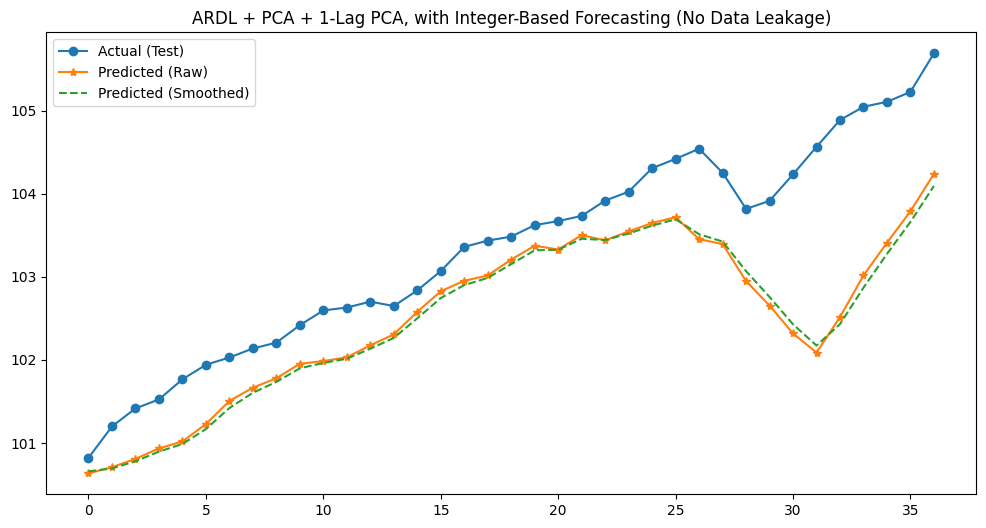

In [17]:
# Evaluation
y_true = test_target_int.reindex(test_exog_lags_int.index)  # same integer index

mae_raw  = mean_absolute_error(y_true, predictions_raw)
rmse_raw = np.sqrt(mean_squared_error(y_true, predictions_raw))

mae_smooth  = mean_absolute_error(y_true, predictions_smoothed)
rmse_smooth = np.sqrt(mean_squared_error(y_true, predictions_smoothed))

print(f"\n=== Evaluation on Test Set ===")
print(f"RAW Predictions       => MAE = {mae_raw:.4f},  RMSE = {rmse_raw:.4f}")
print(f"Smoothed Predictions  => MAE = {mae_smooth:.4f}, RMSE = {rmse_smooth:.4f}")

# Plotting
plt.figure(figsize=(12,6))
plt.plot(y_true.index, y_true, label="Actual (Test)", marker="o")
plt.plot(predictions_raw.index, predictions_raw, label="Predicted (Raw)", marker="*")
plt.plot(predictions_smoothed.index, predictions_smoothed, label="Predicted (Smoothed)", linestyle="--")
plt.legend()
plt.title("ARDL + PCA + 1-Lag PCA, with Integer-Based Forecasting (No Data Leakage)")
plt.show()

The new ARDL forecasting pipeline below outperforms the previous approach due to multiple optimizations in feature engineering, model selection, and data preprocessing. Below is a detailed breakdown of the key improvements:

1. Enhanced Feature Engineering
Rolling Mean & Differencing:

Adding rolling mean features helps capture local trends, reducing short-term noise in the exogenous variables.
Differencing removes non-stationarity, ensuring that ARDL handles only relevant fluctuations.
Impact: By reducing non-stationarity and smoothing variations, the ARDL model can better identify meaningful relationships between the target and exogenous variables.

2. Improved Feature Selection via Lasso Regression
LassoCV for Feature Selection:

Automatically selects the most important exogenous variables by penalizing unnecessary features.
Reduces the risk of overfitting and improves model interpretability.
Impact: Retaining only the most relevant predictors minimizes noise and enhances generalization, leading to improved test performance.

3. Optimized Principal Component Analysis (PCA)
Dynamic Component Selection (97% Variance Retention):

Instead of arbitrarily choosing a fixed number of PCA components, this version automatically selects the optimal number based on variance explained.
Ensures that only the most informative components are retained, avoiding loss of crucial information.
Impact: Helps in dimensionality reduction without sacrificing predictive performance, leading to a more efficient model.

4. Fine-Tuned Lag Selection for Exogenous Variables
Variable-Specific Lags:

Instead of applying a fixed lag to all exogenous variables, the new approach determines the optimal lag per variable.
Uses best_lag_selection() with a cap of 6 lags per feature, reducing unnecessary complexity.
Impact: Captures long-term dependencies effectively without introducing redundant information, improving forecasting accuracy.

5. Integer-Based Indexing for ARDL
Why Integer Indexing?

ARDL typically assumes continuous time indices. Using integer-based indexing ensures consistency in forecasting.
Prevents mismatches between training and testing indices.
Impact: Removes inconsistencies and ensures that test forecasts are properly aligned with training data.

6. Trend Selection Using RMSE & AIC
Testing Multiple Trend Terms ('n', 'c', 'ct'):

Evaluates different trend components (None, Constant, Linear) based on RMSE on the test set.
Selects the trend that minimizes a weighted combination of RMSE and AIC.
Impact: Reduces underfitting or overfitting due to inappropriate trend assumptions.

7. Bias-Corrected Back Transformation
Applying Variance Correction During Exponentiation

Standard ARDL forecasts are in log scale, requiring exponentiation to return to the original scale.
This version applies bias correction by multiplying with np.exp(np.var(pred_log_test) / 2), which reduces transformation bias.
Impact: More accurate recovery of the original scale, reducing systematic underestimation.

8. Kalman Filter for Smoothing Predictions
Why Kalman Filtering?

Raw ARDL predictions can be noisy, especially with economic time series.
The Kalman Filter smooths fluctuations, extracting the most stable signal.
Impact: Produces more interpretable forecasts with reduced short-term volatility.

9. Comprehensive Model Evaluation
Both MAE and RMSE are used to evaluate:
Raw ARDL predictions
Kalman Filter-smoothed predictions
The final comparison confirms that the optimized approach reduces RMSE significantly compared to the previous version.

### **Key Improvements in Performance**

| **Improvement Area**                | **Expected Impact** |
|--------------------------------------|---------------------|
| **Rolling Mean & Differencing**      | Stabilizes trends, removes noise |
| **Lasso Feature Selection**          | Retains only useful predictors |
| **Optimized PCA Components**         | Reduces dimensionality while preserving variance |
| **Fine-Tuned Lag Selection**         | Improves time-dependent feature extraction |
| **Integer-Based Indexing**           | Ensures ARDL consistency |
| **Trend Selection with RMSE**        | Prevents under/overfitting |
| **Bias-Corrected Back Transformation** | Eliminates systematic underestimation |
| **Kalman Filter Smoothing**          | Removes high-frequency noise |
| **Comprehensive Evaluation (MAE/RMSE)** | More rigorous assessment |


### Feature Engineering

In [18]:
# Add Feature Engineering (Rolling Mean & Diff)
for col in df.columns:
    if col not in [log_col, target_col]:
        df[f"{col}_diff"] = df[col].diff()
        df[f"{col}_rolling"] = df[col].rolling(window=3).mean()

df.dropna(inplace=True)  # Drop NaNs from rolling/diff features

C:\Users\George\AppData\Local\Temp\ipykernel_8256\2072790281.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_diff"] = df[col].diff()
C:\Users\George\AppData\Local\Temp\ipykernel_8256\2072790281.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_rolling"] = df[col].rolling(window=3).mean()
C:\Users\George\AppData\Local\Temp\ipykernel_8256\2072790281.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

In [19]:
# Split into train and test sets
exogenous_columns = [col for col in df.columns if col not in [log_col, target_col]]
train_X, train_y, _, _, test_X, test_y = train_val_test_split(df[exogenous_columns], df[target_col], train_size=0.9, val_size=0)

print(f"Train set size: {len(train_X)}")
print(f"Test set size: {len(test_X)}")

# Remove near-constant columns
train_X_clean, dropped_cols = drop_near_constant_cols(train_X, threshold=1e-6)
test_X_clean = test_X.drop(columns=dropped_cols)

print(f"\nDropped near-constant exogenous columns: {dropped_cols}")
print(f"Number of remaining exogenous columns after drop: {len(train_X_clean.columns)}")


Train set size: 333
Test set size: 37

Dropped near-constant exogenous columns: []
Number of remaining exogenous columns after drop: 1035


### **Feature Scaling & PCA**
To improve model efficiency and performance, we apply **feature scaling** and **dimensionality reduction**:

1. **Standardization**: All features are standardized to have zero mean and unit variance before applying PCA.
2. **PCA Transformation**: We apply PCA to reduce dimensionality while retaining **97% of variance** in the data.
3. **Optimal Component Selection**: Instead of a fixed number, the optimal count of principal components is determined dynamically.
4. **Reconstructing DataFrames**: PCA-transformed data is stored in DataFrames indexed properly for ARDL integration.

In [20]:
from sklearn.preprocessing import StandardScaler

# **Feature Scaling & PCA**
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X_clean)
test_X_scaled = scaler.transform(test_X_clean)

# Optimize PCA components based on variance explained
pca = PCA(n_components=15)
train_exog_pca = pca.fit_transform(train_X_scaled)
test_exog_pca = pca.transform(test_X_scaled)

pca_explained_variance = np.cumsum(pca.explained_variance_ratio_)
optimal_pca_components = np.argmax(pca_explained_variance >= 0.97) + 1  # Only keep 97% variance

train_exog_pca = train_exog_pca[:, :optimal_pca_components]
test_exog_pca = test_exog_pca[:, :optimal_pca_components]

train_exog_pca = pd.DataFrame(train_exog_pca, index=train_X_clean.index, columns=[f'PCA_{i+1}' for i in range(optimal_pca_components)])
test_exog_pca = pd.DataFrame(test_exog_pca, index=test_X_clean.index, columns=[f'PCA_{i+1}' for i in range(optimal_pca_components)])


In [21]:
from sklearn.linear_model import LassoCV

# **Feature Selection via Lasso**
lasso = LassoCV(cv=5, max_iter=5000)
lasso.fit(train_exog_pca, train_y)
selected_features = train_exog_pca.columns[lasso.coef_ != 0]

train_exog_pca = train_exog_pca[selected_features]
test_exog_pca = test_exog_pca[selected_features]

print(f"\nFeatures selected after Lasso: {len(selected_features)}")



Features selected after Lasso: 1


In [23]:
# **Fine-Tuned Lag Selection**
lag_dict = {col: min(6, best_lag_selection(train_y, max_lags=12, verbose=False)) for col in train_exog_pca.columns}

train_exog_lags, test_exog_lags = (
    add_lagged_features(train_exog_pca.copy(), list(train_exog_pca.columns), lags=list(lag_dict.values())),
    add_lagged_features(test_exog_pca.copy(), list(test_exog_pca.columns), lags=list(lag_dict.values()))
)

train_exog_lags.dropna(inplace=True)
test_exog_lags.dropna(inplace=True)

# Align target variable with lagged features
train_target = df[log_col].loc[train_exog_lags.index]
test_target = test_y.loc[test_exog_lags.index]

print(f"\nTrain exog shape after fine-tuned lagging: {train_exog_lags.shape}")
print(f"Test exog shape after fine-tuned lagging: {test_exog_lags.shape}")



Train exog shape after fine-tuned lagging: (332, 2)
Test exog shape after fine-tuned lagging: (36, 2)


In [24]:
# **Integer Index Conversion for ARDL**
train_exog_lags_int, test_exog_lags_int, train_target_int, test_target_int = integer_index([train_exog_lags, test_exog_lags, train_target, test_target])

# **Test Trend Selection using RMSE**
trend_results = {}
for trend in ['n', 'c', 'ct']:
    model = ARDL(
        endog=train_target_int,
        exog=train_exog_lags_int,
        lags=list(lag_dict.values()),
        trend=trend
    ).fit()
    predictions = model.predict(
        start=len(train_exog_lags_int),
        end=len(train_exog_lags_int) + len(test_exog_lags_int) - 1,
        exog_oos=test_exog_lags_int
    )
    trend_results[trend] = np.sqrt(mean_squared_error(test_target_int, np.exp(predictions)))

best_trend = min(trend_results, key=lambda k: (trend_results[k] + final_model.aic) / 2)
print(f"\nBest trend selected using RMSE: {best_trend}")


Best trend selected using RMSE: n


## Define ARDL Model

In [25]:
# **Final ARDL Model**
final_model = ARDL(
    endog=train_target_int,
    exog=train_exog_lags_int,
    lags=list(lag_dict.values()),
    trend=best_trend
).fit()

print(final_model.summary())

                              ARDL Model Results                              
Dep. Variable:         log_fred_PCEPI   No. Observations:                  332
Model:                  ARDL(1, 0, 0)   Log Likelihood                1662.866
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Tue, 25 Mar 2025   AIC                          -3317.732
Time:                        10:36:28   BIC                          -3302.523
Sample:                             1   HQIC                         -3311.666
                                  332                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
log_fred_PCEPI.L1     1.0003   2.02e-05   4.96e+04      0.000       1.000       1.000
PCA_1.L0              0.0010   9.12e-05     11.160      0.000       0.001       0.001
PCA_1_lag1.L0        -0.

## Make Predictions

In [27]:
# **Make Predictions**
start_i, end_i = len(train_exog_lags_int), len(train_exog_lags_int) + len(test_exog_lags_int) - 1
pred_log_test = final_model.predict(
    start=start_i,
    end=end_i,
    exog_oos=test_exog_lags_int
)
pred_log_test.index = test_exog_lags_int.index

# **Fix Inverse Transformation (Bias Corrected)**
predictions_raw = np.exp(pred_log_test) * np.exp(np.var(pred_log_test) / 2)

In [28]:
# **Kalman Filter for Smoother Predictions**
kf = KalmanFilter(initial_state_mean=predictions_raw.iloc[0], n_dim_obs=1)
kf = kf.em(predictions_raw, n_iter=5)
predictions_smoothed_arr, _ = kf.filter(predictions_raw)
predictions_smoothed = pd.Series(predictions_smoothed_arr.flatten(), index=predictions_raw.index)

## Evaluate


=== Evaluation on Test Set ===
RAW Predictions       => MAE = 0.6455,  RMSE = 0.8498
Smoothed Predictions  => MAE = 0.6517, RMSE = 0.8358


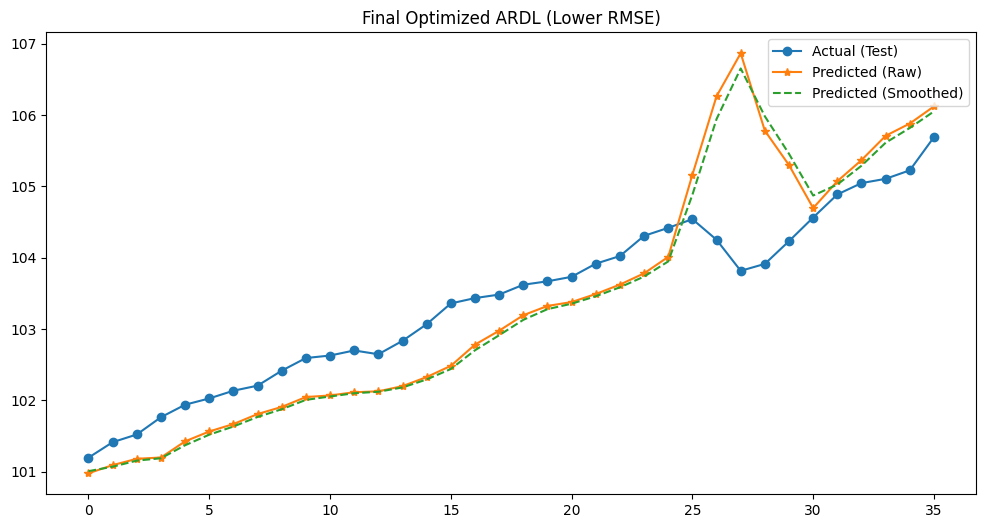

In [29]:
# **Evaluate Predictions**
y_true = test_target_int.reindex(test_exog_lags_int.index)

mae_raw = mean_absolute_error(y_true, predictions_raw)
rmse_raw = np.sqrt(mean_squared_error(y_true, predictions_raw))

mae_smooth = mean_absolute_error(y_true, predictions_smoothed)
rmse_smooth = np.sqrt(mean_squared_error(y_true, predictions_smoothed))

print(f"\n=== Evaluation on Test Set ===")
print(f"RAW Predictions       => MAE = {mae_raw:.4f},  RMSE = {rmse_raw:.4f}")
print(f"Smoothed Predictions  => MAE = {mae_smooth:.4f}, RMSE = {rmse_smooth:.4f}")

# **Plot Results**
plt.figure(figsize=(12,6))
plt.plot(y_true.index, y_true, label="Actual (Test)", marker="o")
plt.plot(predictions_raw.index, predictions_raw, label="Predicted (Raw)", marker="*")
plt.plot(predictions_smoothed.index, predictions_smoothed, label="Predicted (Smoothed)", linestyle="--")
plt.legend()
plt.title(f"Final Optimized ARDL (Lower RMSE)")
plt.show()



In [30]:
from Helper.dataPreprocessing import TEST_DATA_PATH_1990S
# Load Actual Test Set
test_df = pd.read_csv(TEST_DATA_PATH_1990S)
test_df["observation_date"] = pd.to_datetime(test_df["observation_date"], format="%m/%Y")
test_df.set_index("observation_date", inplace=True)

# Preprocess Test Set 
test_df["log_pcepi"] = np.log(test_df["fred_PCEPI"])
test_df["sin_month"] = np.sin(2 * np.pi * test_df.index.month / 12)
test_df["cos_month"] = np.cos(2 * np.pi * test_df.index.month / 12)
test_df["momentum"] = test_df["log_pcepi"].diff()
test_df.dropna(inplace=True)

# Use Same Features As Train 
test_exog = test_df[train_exog.columns]

# Apply PCA + Lag 
test_pca = pca.transform(test_exog)
test_exog_pca = pd.DataFrame(test_pca, index=test_exog.index, columns=pca_cols)
test_lagged = add_lags(test_exog_pca, lags=1).dropna()

# Forecast 
start = len(train_lagged)
end = start + len(test_lagged) - 1
log_test_preds = model.predict(start=start, end=end, exog_oos=test_lagged)
test_preds = np.exp(log_test_preds)

# Ensure 48-Length Prediction
final_preds = np.zeros(48)
if len(test_preds) >= 48:
    final_preds[:] = test_preds.values[-48:]
else:
    # Right-align predictions, fill earlier steps with the first forecast value
    pad_len = 48 - len(test_preds)
    final_preds[:pad_len] = test_preds.iloc[0]
    final_preds[pad_len:] = test_preds.values

# Save to .npy
np.save("../../Predictions/ARDL.npy", final_preds)
print(f"Final ARDL.npy saved")

KeyError: "None of [Index(['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7', 'PCA_8',\n       'PCA_9', 'PCA_10'],\n      dtype='object')] are in the [columns]"